# imitools Dev

The devtool for imitools.

## Todo

* ~Introduce the wrap & from_path funtions~
* ~convert the codebase to keep a list of pils~
* ~support loading files from directories~
* ~save a wrap to a disk (directory)~
* ~create a video from a disk~

In [1]:
# # install ffmpeg
# !apt update -y > /dev/null 2>&1
# !DEBIAN_FRONTEND=noninteractive apt -y install ffmpeg > /dev/null 2>&1

## Later

* ~multithreading support when saving images~
* immutability when returning pil
* add a map function
* Download images from duckduck go
* multithreading when reading images

In [3]:
device = "cuda"

In [17]:
from __future__ import annotations

from PIL import Image, UnidentifiedImageError
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
import math
from pathlib import Path
from IPython.display import  display, HTML
from base64 import b64encode
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import io
import requests
import tempfile

class ImageDefaults:
    def __init__(self):
        self.device = "cpu"
        
defaults = ImageDefaults()

def download_image(img_url):
    image = None
    try:
        buffer = tempfile.SpooledTemporaryFile(max_size=1e9)
        r = requests.get(img_url, stream=True)
        if r.status_code == 200:
            for chunk in r.iter_content(chunk_size=1024):
                buffer.write(chunk)
            buffer.seek(0)
            image = Image.open(io.BytesIO(buffer.read()))
        buffer.close()
        return image
    except:
        return image
    
# based on https://gist.github.com/sigilioso/2957026
def image_crop(img, size, crop_type='middle'):
    # Get current and desired ratio for the images
    img_ratio = img.size[0] / float(img.size[1])
    ratio = size[0] / float(size[1])
    #The image is scaled/cropped vertically or horizontally depending on the ratio
    if ratio > img_ratio:
        img = img.resize((size[0], round(size[0] * img.size[1] / img.size[0])),
                Image.ANTIALIAS)
        # Crop in the top, middle or bottom
        if crop_type == 'top':
            box = (0, 0, img.size[0], size[1])
        elif crop_type == 'middle':
            box = (0, round((img.size[1] - size[1]) / 2), img.size[0],
                   round((img.size[1] + size[1]) / 2))
        elif crop_type == 'bottom':
            box = (0, img.size[1] - size[1], img.size[0], img.size[1])
        else :
            raise ValueError('ERROR: invalid value for crop_type')
        img = img.crop(box)
    elif ratio < img_ratio:
        img = img.resize((round(size[1] * img.size[0] / img.size[1]), size[1]),
                Image.ANTIALIAS)
        # Crop in the top, middle or bottom
        if crop_type == 'top':
            box = (0, 0, size[0], img.size[1])
        elif crop_type == 'middle':
            box = (round((img.size[0] - size[0]) / 2), 0,
                   round((img.size[0] + size[0]) / 2), img.size[1])
        elif crop_type == 'bottom':
            box = (img.size[0] - size[0], 0, img.size[0], img.size[1])
        else :
            raise ValueError('ERROR: invalid value for crop_type')
        img = img.crop(box)
    else :
        img = img.resize((size[0], size[1]),
                Image.ANTIALIAS)

    return img
    
def thread_loop(fn, input_array, n_workers=min(10, os.cpu_count())):        
    return_data = []
    
    with ThreadPoolExecutor(n_workers) as executor:
        futures = [executor.submit(fn, input_item) for input_item in input_array]
        
        for future in as_completed(futures):
            result = future.result()
            return_data.append(result)
            
    return return_data

class VideoWrapper:
    def __init__(self, video_path, video_size):
        self.video_path = video_path
        self.video_size = video_size
        
    def path(self):
        return self.video_path
    
    def show(self):
        mp4 = open(self.video_path, 'rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        
        width, height = self.video_size
        
        return HTML(f"""
        <video width={width} height={height} controls>
              <source src="%s" type="video/mp4">
        </video>
        """ % data_url)

class ImageWrapper:
    def __init__(self, data, image_type, labels=None):
        self.data = data
        self.image_type = image_type
        self.labels = list(range(len(data))) if labels is None else labels
        
    def resize(self, size=(256, 256), **kwargs) -> ImageWrapper:
        ref = self
        if self.image_type != "pil":
            ref = ref.cpil()
            
        if not isinstance(size, tuple):
            size = (size, size)
            
        i_size = (int(size[0]), int(size[1]))
            
        new_images = [im.resize(i_size, **kwargs) for im in ref.data]
        return ImageWrapper(new_images, "pil")
    
    def crop(self, size=(256, 256), crop_type="middle") -> ImageWrapper:
        ref = self
        if self.image_type != "pil":
            ref = ref.cpil()
            
        if not isinstance(size, tuple):
            size = (size, size)
            
        i_size = (int(size[0]), int(size[1]))
            
        new_images = [image_crop(im, size, crop_type) for im in ref.data]
        return ImageWrapper(new_images, "pil")
    
    def normalize(self) -> ImageWrapper:
        ref = self
        if self.image_type != "pt":
            ref = self.cpt()
        
        normalized = (ref.data - ref.data.min()) / (ref.data.max() - ref.data.min())
        return ImageWrapper(normalized, "pt")
    
    def pick(self, *args):
        if len(args) == 0:
            raise Exception("provide some indexes to pick")

        indexes = list(args)
        if isinstance(args[0], list):
            indexes = args[0]

        if self.image_type == "pil":
            return ImageWrapper([self.data[i] for i in indexes], "pil")
        
        if self.image_type == "pt":
            return ImageWrapper(self.data[indexes], "pt")
    
    def sinrange(self) -> ImageWrapper:
        ref = self
        if self.image_type != "pt":
            ref = self.cpt()
        
        return ImageWrapper(ref.data * 2 - 1, "pt")
        
    def pil(self) -> Image:
        if self.image_type == "pil":
            return self.data[0] if len(self.data) == 1 else self.data
        
        if self.image_type == "pt":
            make_pil = transforms.ToPILImage()
            pt_images = self.data.cpu()
            pil_images = [make_pil(i) for i in pt_images]
            return pil_images[0] if len(pil_images) == 1 else pil_images
    
    def pt(self) -> torch.Tensor:            
        if self.image_type == "pil":
            pt_images = [transforms.ToTensor()(im) for im in self.data]
            return torch.stack(pt_images).to(defaults.device)
        
        if self.image_type == "pt":
            return self.data
        
    def to(self, device="cpu") -> ImageWrapper:
        if self.image_type != "pt":
            raise Exception("to() only applied for pytorch tensors")
        
        return ImageWrapper(self.data.to(device), "pt")
    
    def cpil(self) -> ImageWrapper:
        images = self.pil()
        if isinstance(images, Image.Image):
            images = [images]
            
        return ImageWrapper(images, "pil")
    
    def cpt(self) -> ImageWrapper:
        return ImageWrapper(self.pt(), "pt")
    
    def show(self, cmap=None, figsize=None, cols=6, max_count=36, scale=-1, captions=True):        
        if len(self.data) == 1:
            scale = 4 if scale == -1 else scale
            plt.figure(figsize=(scale, scale))
            plt.axis("off")
            if self.image_type == "pil":
                plt.imshow(self.data[0], cmap=cmap)
            else:
                plt.imshow(self.data[0].permute(1, 2, 0).cpu(), cmap=cmap)
                
            return
        
        scale = 2.5 if scale == -1 else scale
        images = self.data.cpu() if self.image_type == "pt" else self.data
        labels = self.labels
        image_count = len(self.data)
        
        if image_count > max_count:
            print(f"Only showing {max_count} images of the total {image_count}. Use the `max_count` parameter to change it.")
            images = self.data[0:max_count]
            image_count = max_count
            
        if image_count < cols:
            cols = image_count
            
        rows = math.ceil(image_count / cols)
        
        if figsize == None:
            figsize = figsize=(cols*scale, rows*scale)
            
        _, ax = plt.subplots(rows, cols, figsize=figsize)
        if (rows == 1):
            for i in range(image_count):
                image = images[i] if self.image_type == "pil" else images[i].permute(1, 2, 0)
                ax[i].imshow(image)
                ax[i].axis("off")
                if captions: ax[i].set_title(f"{labels[i]}")
        else:
            for row in range(rows):
                for col in range(cols):
                    i = row * cols + col
                    if i < image_count:
                        image = images[i] if self.image_type == "pil" else images[i].permute(1, 2, 0)
                        ax[row][col].imshow(image)
                        ax[row][col].axis("off")
                        if captions: ax[row][col].set_title(f"{labels[i]}")
                    else:
                        ax[row][col].axis("off")
                        
    def to_dir(self, output_dir, prefix="image", max_workers=min(10, os.cpu_count())):
        ref = self
        if self.image_type != "pil":
            ref = self.cpil()
            
        dir_path = Path(output_dir)
        dir_path.mkdir(exist_ok=True, parents=True)
        
        images = ref.data

        def save_image(i):
            try:
                path = Path(output_dir)/f"{prefix}_{i:04}.png"
                images[i].save(path)
            except Exception as e:
                print("image saving error:", e)
        
        thread_loop(save_image, range(len(images)))


    def to_video(self, out_path=None, frame_rate=12):
        ref = self
        if self.image_type == "pt":
            ref = self.cpil()
            
        id = int(torch.rand(1)[0].item() * 9999999)
        image_dir = Path(f'/tmp/{id}/images')
        image_dir.mkdir(exist_ok=True, parents=True)

        if out_path == None:
            out_path = f"/tmp/{id}/video.mp4"

        video_path = Path(out_path)
        video_size = ref.data[0].size
        images_selector = image_dir/"image_%04d.png"
        
        ref.to_dir(image_dir, prefix="image")

        command = f"ffmpeg -v 0 -y -f image2 -framerate {frame_rate} -i {images_selector} -c:v h264_nvenc -preset slow -qp 18 -pix_fmt yuv420p {video_path}"
        os.system(command)
    
        return VideoWrapper(video_path, video_size)

def wrap(input_data, labels=None) -> ImageWrapper:
    if isinstance(input_data, ImageWrapper):
        return input_data
    
    if isinstance(input_data, torch.Tensor):
        if len(input_data.shape) == 3:
            input_data = input_data.unsqueeze(0)
            
        return ImageWrapper(input_data.detach().float(), "pt", labels)
    
    if isinstance(input_data, Image.Image):
        return ImageWrapper([input_data], "pil", labels)
    
    if isinstance(input_data, list):
        if isinstance(input_data[0], torch.Tensor):
            images = torch.stack(input_data).squeeze(1).detach().float()
            return ImageWrapper(images, "pt", labels)
        
        if isinstance(input_data[0], Image.Image):
            return ImageWrapper(input_data, "pil", labels)
        
        if isinstance(input_data[0], ImageWrapper):
            image_list = list(map(lambda w: w.pt(), input_data))
            images = torch.stack(image_list).squeeze(1).detach().float()
            return ImageWrapper(images, "pt", labels)
    
    raise Exception("not implemented!")                        
                        
def from_dir(dir_path) -> ImageWrapper:
    file_list = [f for f in Path(dir_path).iterdir() if not f.is_dir()]
    image_list = []
    
    def read_image(f):
        try:
            image_list.append(Image.open(f).convert("RGB"))
        except UnidentifiedImageError:
            None
            
    thread_loop(read_image, file_list)
            
    return ImageWrapper(image_list, "pil")

def from_path(input_data) -> ImageWrapper:
    pil_image = Image.open(input_data).convert("RGB")
    return ImageWrapper([pil_image], "pil")
                        

class LivePlotter:
    def __init__(self, cols=2, figsize=(15, 4)):
        fig, subplots = plt.subplots(1, cols, figsize=(20, 5))
        fig.patch.set_facecolor("white")
        fig.tight_layout()
        out = display(fig, display_id=True)

        self.cols = cols
        self.fig = fig
        self.out = out
        self.subplots = subplots
        
        self.queue = []
        
    def plot(self, subplot_id, *args, **kwargs) -> DynaPlot:
        self.queue.append((
            "plot", subplot_id, args, kwargs
        ))
        return self
    
    def title(self, subplot_id, title)-> DynaPlot:
        self.queue.append((
            "title", subplot_id, title
        ))
        return self
        
    def imshow(self, subplot_id, image)-> DynaPlot:
        self.queue.append((
            "imshow", subplot_id, image
        ))
        return self
        
    def update(self):
        for col in range(self.cols):
            if self.cols == 1:
                self.subplots.clear()
            else:
                self.subplots[col].clear()
        
        for item in self.queue:
            if item[0] == "imshow":
                _, subplot_id, image = item
                if self.cols == 1:
                    self.subplots.imshow(wrap(image).pt().detach().cpu()[0].permute(1, 2, 0))
                    self.subplots.axis("off")
                else:
                    self.subplots[subplot_id].imshow(wrap(image).pt().detach().cpu()[0].permute(1, 2, 0))
                    self.subplots[subplot_id].axis("off")
            
            if item[0] == "plot":
                _, subplot_id, args, kwargs = item
                self.subplots[subplot_id].plot(*args, **kwargs)
                if "label" in kwargs:
                    self.subplots[subplot_id].legend()
                
            if item[0] == "title":
                _, subplot_id, title = item
                self.subplots[subplot_id].title.set_text(title)
                
        self.queue = []
        self.out.update(self.fig)
        
    def close(self):
        plt.close()
    
def live_plot(*args, **kwargs) -> LivePlotter:
    return LivePlotter(*args, **kwargs)

def download(image_urls):
    if isinstance(image_urls, str):
        image_urls = [image_urls]
    
    result_list = thread_loop(download_image, image_urls)
    images = []
    for image in result_list:
        if image is None:
            continue
        images.append(image)
        
    return wrap(images)

def merge(*args):
    args = list(args)
    if isinstance(args[0], list) and not isinstance(args[0][0], Image.Image):
        args = args[0]
        
    wrappers = [wrap(i) for i in args]
        
    if wrappers[0].image_type == "pil":
        images = []
        for w in wrappers:
            convered = w.cpil()
            for i in convered.data:
                images.append(i)
                
        return ImageWrapper(images, "pil")
    
    if wrappers[0].image_type == "pt":
        tensor_list = [w.pt() for w in wrappers]
        return ImageWrapper(torch.cat(tensor_list, dim=0), "pt")

class ImiTools:
    def __init__(self):
        self.defaults = defaults
        
    def wrap(self, data, labels=None) -> ImageWrapper:
        return wrap(data, labels)
                        
    def from_path(self, path) -> ImageWrapper:
        return from_path(path)
    
    def from_dir(self, path) -> ImageWrapper:
        return from_dir(path)
    
    def live_plot(self, *args, **kwargs) -> LivePlotter:
        return live_plot(*args, **kwargs)
    
    def download(self, img_urls) -> ImageWrapper:
        return download(img_urls)
    
    def merge(self, *args) -> ImageWrapper:
        return merge(*args)
    
I = ImiTools()
I.defaults.device = device


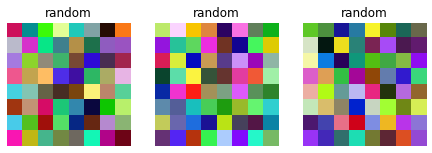

In [23]:
pt_images = torch.rand(3, 3, 8, 8)
I.wrap(pt_images, ["random"] * 3).show()

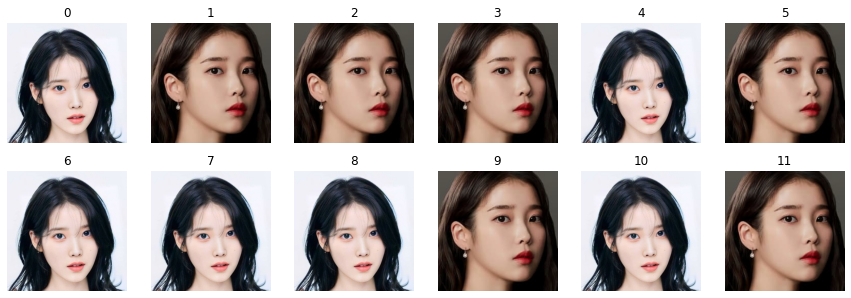

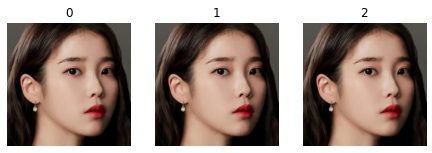

In [6]:
images.pick(0, 1, 2).show()

In [7]:
def kmr(*args):
    print(list(args))
    
kmr(1, 2, 3)

[1, 2, 3]


In [8]:
i1 = images.pick(0, 9)
i2 = images.pick(5, 10)

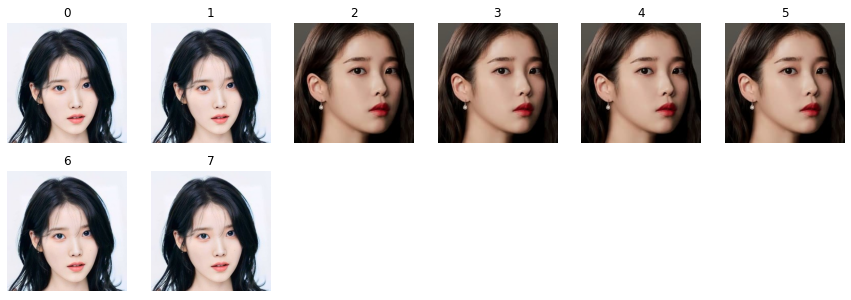

In [31]:
I.merge(i2.pt(), i1.pil(), i1, i2).show()

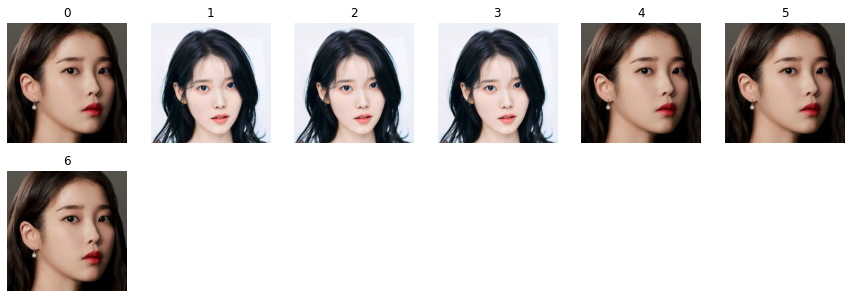

In [37]:
I.merge(i1.pt()[0], i2.pil()[0], i2, i1.pt(), i1.pt()[0]).show()